In [9]:
import pandas as pd
import numpy as np


### Fitting of the polynomial

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def optimize_polynomial_degree(data1, energy_diff, max_degree=10):
    """
    Optimize the polynomial degree by using cross-validation and selecting the best degree based on MSE.

    Parameters:
        data1 (pd.DataFrame): The dataset with 'cell_length' column.
        energy_diff (pd.Series): The energy difference data.
        max_degree (int): The maximum degree to consider for polynomial fitting. Default is 10.
    
    Returns:
        tuple: (best_degree, best_mse) - The optimal polynomial degree and the corresponding MSE.
    """
    best_degree = None
    best_mse = float('inf')  # Start with an infinitely large MSE to minimize it
    
    # Prepare the data
    X = data1['cell_length'].values.reshape(-1, 1)
    y = energy_diff.values

    # Remove rows where y has NaN values
    valid_indices = ~np.isnan(y)
    X = X[valid_indices]
    y = y[valid_indices]

    print(y)
    
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    for degree in range(1, max_degree + 1):
        # Generate polynomial features for the current degree
        poly_features = PolynomialFeatures(degree=degree)
        X_train_poly = poly_features.fit_transform(X_train)
        X_val_poly = poly_features.transform(X_val)
        
        # Fit the model
        model = LinearRegression()
        model.fit(X_train_poly, y_train)
        
        # Make predictions on the validation set
        y_pred = model.predict(X_val_poly)
        
        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_val, y_pred)
        
        # If this MSE is better, update the best degree and MSE
        if mse < best_mse:
            best_mse = mse
            best_degree = degree


    
    print(f"Optimal Polynomial Degree: {best_degree} with MSE: {best_mse:.4f}")
    return best_degree, best_mse

def find_polynomial_maximum_with_optimal_degree(data1, energy_diff, max_degree=10):
    """
    Fit a polynomial regression to the data with an optimized degree and find the maximum value of the polynomial curve.

    Parameters:
        data1 (pd.DataFrame): The dataset with 'cell_length' column.
        energy_diff (pd.Series): The energy difference data.
        max_degree (int): The maximum degree to consider for polynomial fitting. Default is 10.
    
    Returns:
        tuple: (max_cell_length, max_energy_diff) - The cell length and energy difference at the maximum.
    """
    # Remove rows with NaN values from energy_diff and align with data1
    valid_indices = energy_diff.dropna().index
    data1 = data1.loc[valid_indices].reset_index(drop=True)
    energy_diff = energy_diff.dropna().reset_index(drop=True)

    # Find the optimal polynomial degree
    # optimal_degree, _ = optimize_polynomial_degree(data1, energy_diff, max_degree=max_degree)
    
    optimal_degree = max_degree

    # Prepare the polynomial features for the optimal degree
    poly_features = PolynomialFeatures(degree=optimal_degree)
    X_poly = poly_features.fit_transform(data1['cell_length'].values.reshape(-1, 1))
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X_poly, energy_diff)
    
    # Generate finer cell length values for extrapolation
    fine_cell_lengths = np.linspace(min(data1['cell_length']), max(data1['cell_length']), 500)
    fine_cell_lengths_poly = poly_features.transform(fine_cell_lengths.reshape(-1, 1))
    energy_diff_fine = model.predict(fine_cell_lengths_poly)
    
    # Calculate the first derivative (slope) of the fitted polynomial
    poly_coeffs = model.coef_[1:]  # Skip the first coefficient as it corresponds to the constant term
    first_derivative_coeffs = np.polyder(poly_coeffs)
    
    # Find the root of the first derivative (where slope = 0)
    critical_points = np.roots(first_derivative_coeffs)
    
    # We are interested in real roots that fall within the domain of the data
    critical_points_real = [point.real for point in critical_points if point.imag == 0 and min(data1['cell_length']) <= point.real <= max(data1['cell_length'])]
    
    # Evaluate the second derivative to check for maxima
    second_derivative_coeffs = np.polyder(first_derivative_coeffs)
    
    max_cell_length = None
    max_energy_diff = None
    
    for point in critical_points_real:
        # Evaluate the second derivative at each critical point to check for maximum (second derivative < 0)
        second_derivative_value = np.polyval(second_derivative_coeffs, point)
        if second_derivative_value < 0:  # This means it's a maximum
            max_cell_length = point
            max_energy_diff = np.polyval(poly_coeffs, point)
            break
    
    # Plot the original data and polynomial fit
    plt.figure(figsize=(10, 6))
    plt.plot(data1['cell_length'], energy_diff, label='Energy Difference', linestyle='--', marker='o')
    plt.plot(fine_cell_lengths, energy_diff_fine, label=f'Polynomial Fit (Degree {optimal_degree})', linestyle='--')
    # plt.scatter(max_cell_length, max_energy_diff, color='red', label=f'Maximum at {max_cell_length:.3f}')
    
    # Add labels and legend
    plt.xlabel('Cell Length')
    plt.ylabel('Energy Difference')
    plt.title(f'Energy Difference and Polynomial Regression (Optimal Degree {optimal_degree})')
    plt.legend()
    plt.grid()
    
    # Show the plot
    plt.show()

    return max_cell_length, max_energy_diff

# Example usage:
# Assuming `data1` is your dataframe with 'cell_length' and `energy_diff` is your computed energy difference
# max_cell, max_energy = find_polynomial_maximum_with_optimal_degree(data1, energy_diff)


### Finding the Error percent in D3

In [11]:
df = pd.read_csv("features/ff_all.csv")

molecules = df['Mol'].values


molecules = molecules
molecules



array(['LiH', 'NaH', 'KH', 'RbH', 'CsH', 'CsCl', 'LiCl', 'CuI', 'LiF'],
      dtype=object)

In [12]:
single = {
    'Li': -.28818922E+00,
    'Na': -.22270155E+00,
    'K': -.17135154E+00,
    'Rb':-.15464229E+00,
    'Cs': -.12823607E+00,
    'Cu': -.20759677E+00,
    'Mg': 0.11115308E-01,
    'Ca': -.14236721E-01,
    'H': -.11115034E+01,
    'F': -.49422164E+00,
    'Cl': -.31345437E+00,
    'I': -.31345437E+00,
    'C':-.13177377E+01
}

In [13]:
base_values = {
    f'{molecules[0]}' : single['Li']*4 + single['H']*4,
    f'{molecules[1]}' : single['Na']*4 + single['H']*4,
    f'{molecules[2]}' : single['K']*4 + single['H']*4,
    f'{molecules[3]}' : single['Rb']*4 + single['H']*4,
    f'{molecules[4]}' : single['Cs']*4 + single['H']*4,
    f'{molecules[5]}' : single['Cs']*1 + single['Cl']*1,
    f'{molecules[6]}' : single['Li']*4 + single['Cl']*4,
    f'{molecules[7]}' : single['Cu']*4 + single['I']*4,
    f'{molecules[8]}' : single['Li']*4 + single['F']*4
}

base_values

{'LiH': -5.59877048,
 'NaH': -5.3368198,
 'KH': -5.13141976,
 'RbH': -5.0645827599999995,
 'CsH': -4.95895788,
 'CsCl': -0.44169044,
 'LiCl': -2.40657436,
 'CuI': -2.08420456,
 'LiF': -3.12964344}

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compare_energy_data(d3, mbd, comp, offset_ref_index=(6, 0), isPlot=False):
    """
    Compare energy differences between two datasets with different cell lengths.

    Parameters:
        d3 (pd.DataFrame): First dataset with 'cell_length' and 'energy' columns.
        mbd (pd.DataFrame): Second dataset with 'cell_length' and 'energy' columns.
        offset_ref_index (tuple): A tuple specifying indices for offset calculation 
                                  (index for d3['energy'], index for mbd['energy']).
        isPlot (bool): If True, generates a plot comparing datasets and differences.

    Returns:
        float: Percentage change in energy difference relative to the reference energy.
    """
    # Calculate offset based on specified reference indices
    # offset = mbd['energy'][offset_ref_index[1]] - d3['energy'][offset_ref_index[0]]

    # adjusting d3 and mbd values 

    d3['energy'] = d3['energy'] - base_values[comp]
    mbd['energy'] = mbd['energy'] - base_values[comp]
    # Interpolate mbd's energy values at d3's cell_length points
    # Increase granularity by adding finer cell length points
    finer_cell_lengths = np.linspace(min(d3['cell_length']), max(d3['cell_length']), 500)
    mbd_interp = np.interp(finer_cell_lengths, mbd['cell_length'], mbd['E-dispersion'])
    
    # Handle null values in mbd_interp
    mbd_interp = np.nan_to_num(mbd_interp)

    # Interpolate d3's energy to match finer resolution
    d3_interp = np.interp(finer_cell_lengths, d3['cell_length'], d3['E-dispersion'])

    # Calculate the energy difference

    energy_diff = np.where(mbd_interp == 0, 0, mbd_interp - d3_interp)

    # Exclude NaN or zero values from the energy_diff when finding the maximum
    valid_indices = (energy_diff != 0) & (~np.isnan(energy_diff))
    valid_energy_diff = energy_diff[valid_indices]
    valid_cell_lengths = finer_cell_lengths[valid_indices]

    # Identify maximum energy difference and corresponding cell length
    max_diff = max(valid_energy_diff)
    max_diff_index = np.argmax(valid_energy_diff)
    max_diff_cell_length = valid_cell_lengths[max_diff_index]

    # Visualization
    if isPlot:
        plt.figure(figsize=(12, 7))
        plt.plot(d3['cell_length'], d3['E-dispersion'], label='Data 1 (Reference)', marker='o')
        plt.plot(mbd['cell_length'], mbd['E-dispersion'], label='Data 2 (Original)', marker='x')
        plt.plot(finer_cell_lengths, energy_diff, label='Energy Difference', linestyle='--')

        # Mark the maximum energy difference
        plt.scatter(max_diff_cell_length, max_diff, color='red', label=f'Max Diff: {max_diff:.2f} at {max_diff_cell_length:.2f}')
        plt.annotate(f'Max: {max_diff:.2f}\nLength: {max_diff_cell_length:.2f}',
                     xy=(max_diff_cell_length, max_diff),
                     xytext=(max_diff_cell_length + 0.5, max_diff - 0.5),
                     arrowprops=dict(facecolor='red', arrowstyle='->'),
                     fontsize=10, color='red')

        # Add labels and legend
        plt.xlabel('Cell Length')
        plt.ylabel('Energy')
        plt.title('Comparison of Energy vs Cell Length')
        plt.legend()
        plt.grid()

        # Show the plot
        plt.show()

    # energy to divide 
    div_energy = min(d3['energy'])

    
    return abs(max_diff/ div_energy) * 100
    


Processing LiH...


C:\Users\user\AppData\Local\Temp\ipykernel_15004\1085793464.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3['energy'] = d3['energy'] - base_values[comp]


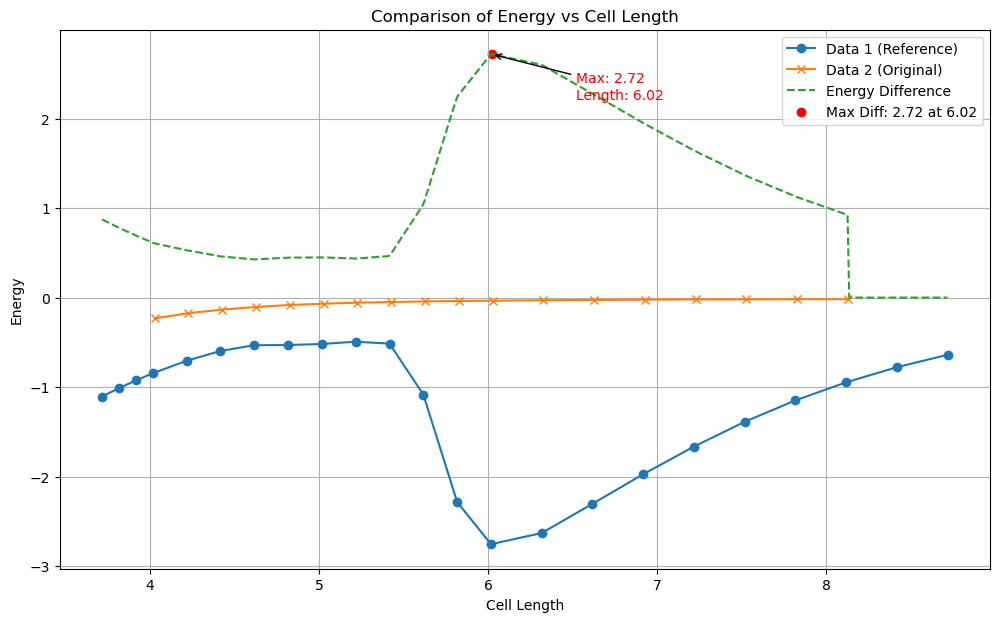

Max difference for LiH: 14.137466826376718
Processing NaH...


C:\Users\user\AppData\Local\Temp\ipykernel_15004\1085793464.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3['energy'] = d3['energy'] - base_values[comp]


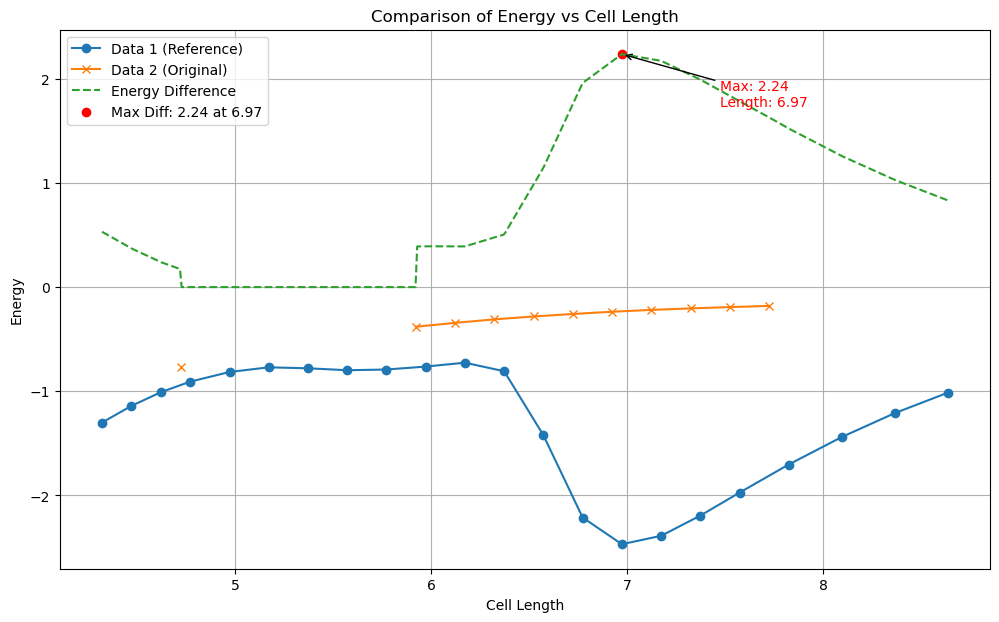

Max difference for NaH: 14.087159279098158
Processing KH...


C:\Users\user\AppData\Local\Temp\ipykernel_15004\1085793464.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3['energy'] = d3['energy'] - base_values[comp]


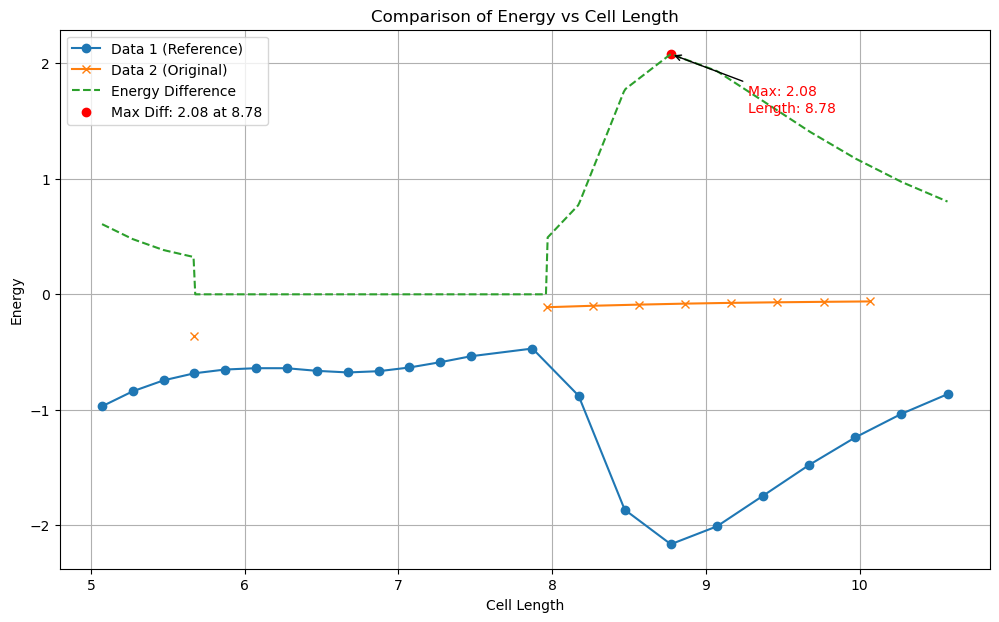

Max difference for KH: 14.02702180402777
Processing RbH...


C:\Users\user\AppData\Local\Temp\ipykernel_15004\1085793464.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3['energy'] = d3['energy'] - base_values[comp]


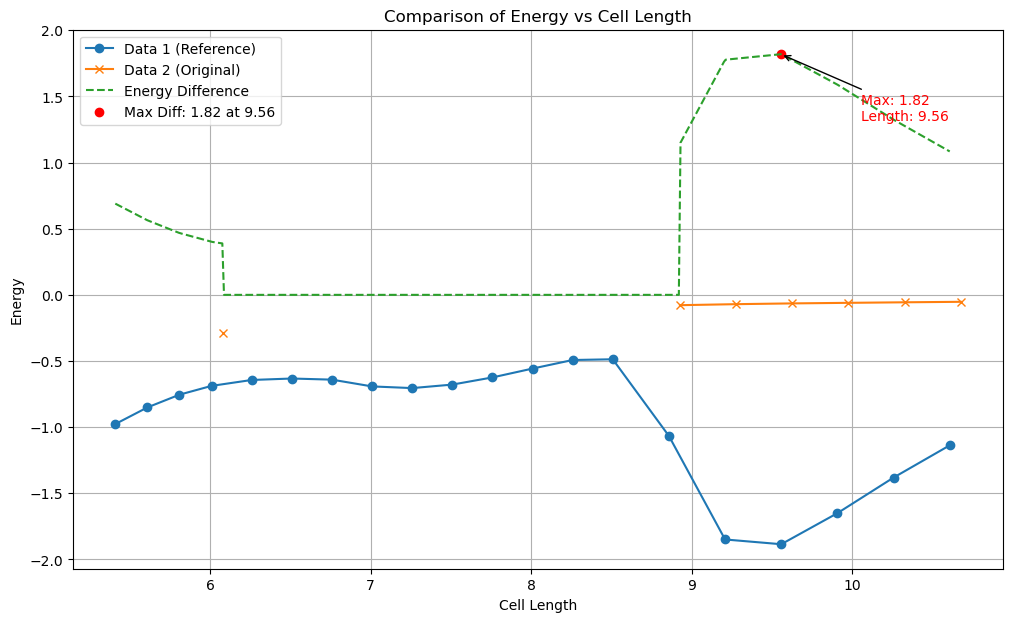

Max difference for RbH: 12.930918115689444
Processing CsH...


C:\Users\user\AppData\Local\Temp\ipykernel_15004\1085793464.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3['energy'] = d3['energy'] - base_values[comp]


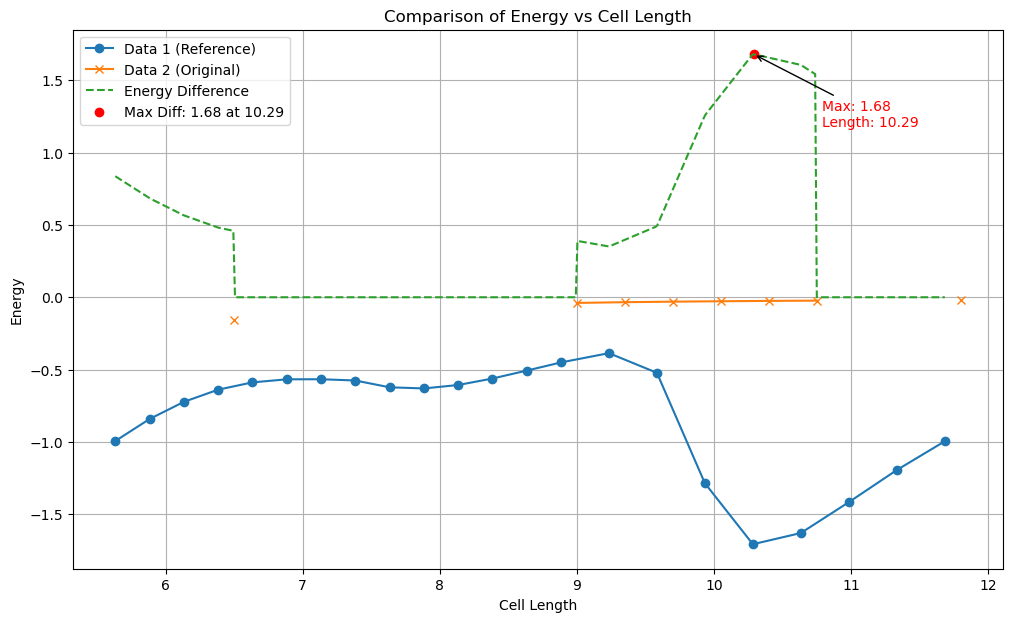

Max difference for CsH: 12.275605094480198
Processing CsCl...


C:\Users\user\AppData\Local\Temp\ipykernel_15004\1085793464.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3['energy'] = d3['energy'] - base_values[comp]


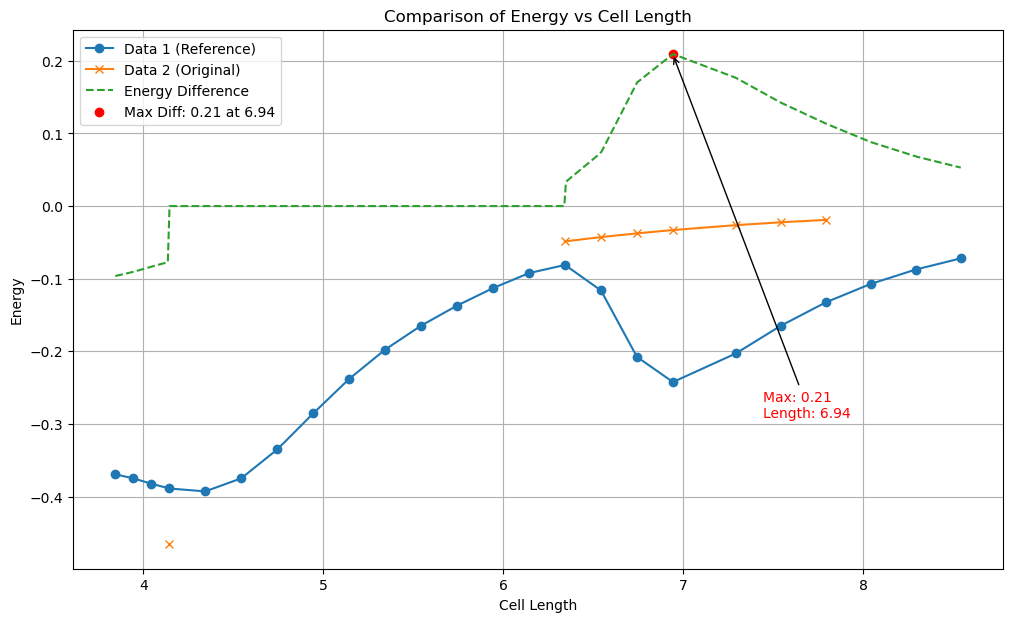

C:\Users\user\AppData\Local\Temp\ipykernel_15004\1085793464.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3['energy'] = d3['energy'] - base_values[comp]


Max difference for CsCl: 3.2325958680570794
Processing LiCl...


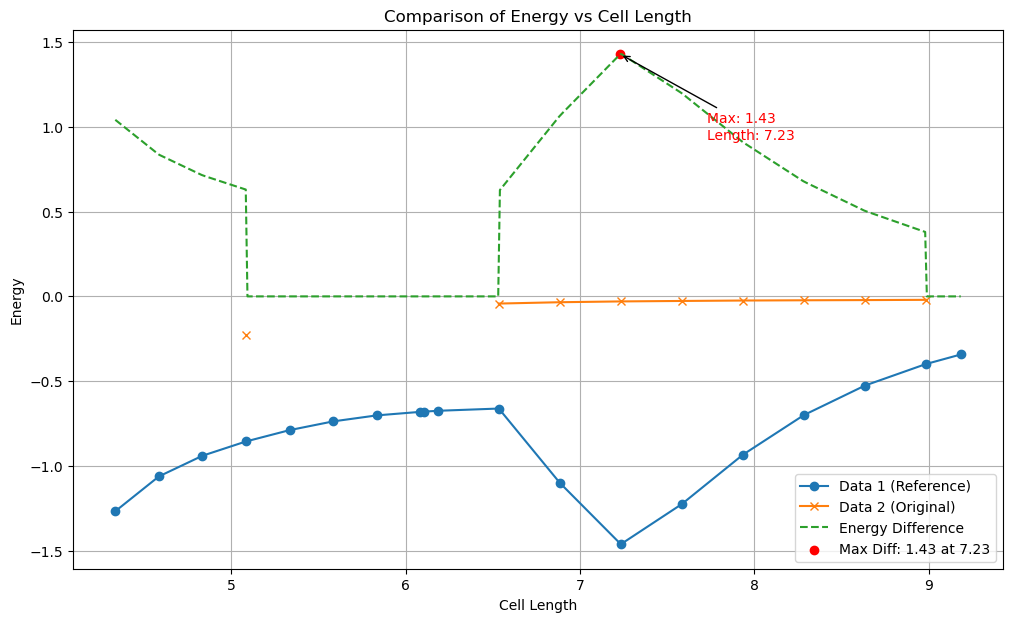

Max difference for LiCl: 5.11791434948661
Processing CuI...


C:\Users\user\AppData\Local\Temp\ipykernel_15004\1085793464.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3['energy'] = d3['energy'] - base_values[comp]
C:\Users\user\AppData\Local\Temp\ipykernel_15004\1085793464.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mbd['energy'] = mbd['energy'] - base_values[comp]


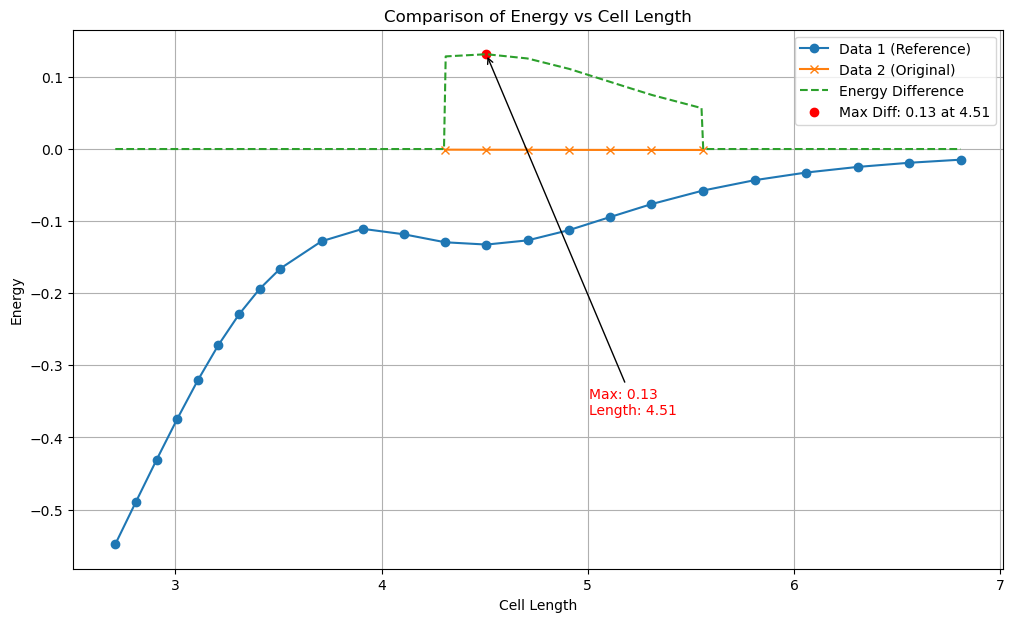

Max difference for CuI: 3.5739198265668453
Processing LiF...


C:\Users\user\AppData\Local\Temp\ipykernel_15004\1085793464.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3['energy'] = d3['energy'] - base_values[comp]


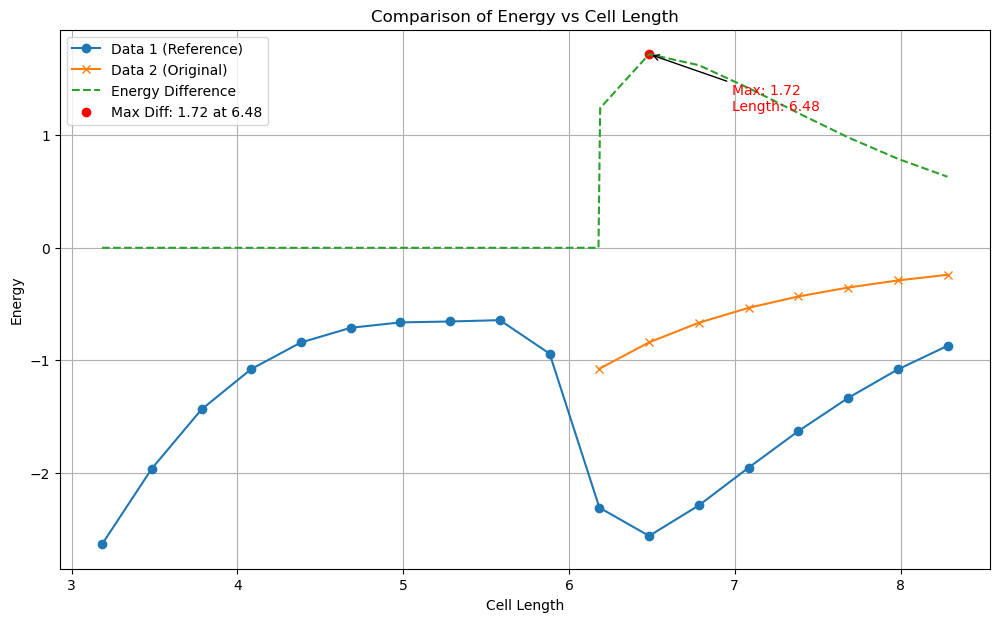

Max difference for LiF: 4.719651538728355


[14.137466826376718,
 14.087159279098158,
 14.02702180402777,
 12.930918115689444,
 12.275605094480198,
 3.2325958680570794,
 5.11791434948661,
 3.5739198265668453,
 4.719651538728355]

In [15]:
res = []

start = 5
end = -1

for comp in molecules:
    print(f"Processing {comp}...")
    d3 = pd.read_csv(f'd3/{comp}.csv')
    mbd = pd.read_csv(f'mbd/{comp}.csv')
    
    if comp == 'CuI':
        ans = compare_energy_data(d3.iloc[2:,],mbd.iloc[1:,], comp, isPlot=True)
    elif comp == 'Cu':
        ans = compare_energy_data(d3.iloc[1:,],mbd, comp,isPlot=True)
    else:
        ans = compare_energy_data(d3.iloc[2:,],mbd, comp,isPlot=True)
    res.append(ans)
    print(f"Max difference for {comp}: {ans}")
    # print(f"Max difference for {comp}: {ans}")

res

In [16]:
%store res

Stored 'res' (list)
